# Assessing university performance worldwide 

## Introduction

Ranking world universities is an often controversial endeavour. Various countries may have different views about education and the role of university in society and about the meaning of education itself. Furthermore, world rankings often mix institutions of non-comparable size and educational scope and use arbitrary parameters in order to obtain an overall performance score. Understanding how these rankings work and how their results can be interpreted is vital for any university who wants to gain more international visibility and attract funding from public and private institutions. This is also important for perspective students, who are faced with the important choice of a college. For this reason, this report will analyze one of the most popular rankings of universities: the Times Higher Education (THE) ranking (see also <https://www.timeshighereducation.com>). It will be shown, for instance, how the weight arbitrarily attributed to certain performance parameters can significantly change the ranking in favour of under-represented countries. Finally, a machine learning algorithm will be applied in order to cluster world universities into groups with similar characteristics. This will highlight the relationship between the various performance indicators that form the overall score.

## Reference data

The database containing the THE ranking for several years is made available on Kaggle by Myles O'Neill at the address <https://www.kaggle.com/mylesoneill/world-university-rankings>. Each university is evaluated with marks ranging from 0 to 100 for the following performance indicators: teaching quality, international outlook, research (considering the sheer volume of papers produced and the reputation of said research), citations, industry income.
The overall score $S$ is the weighted average of the previous parameters according to the following weighted sum:

$S = 0.3*$teaching $+\ 0.275*$international $+\ 0.3*$research $+\ 0.1 *$citations $+\ 0.025 *$income

Additional parameters available in the database are the number of students, the student-to-staff ratio, the percentage of international students and the female-to-male ratio.

## Methodology and data preparation

This section presents the post-processing techniques that have been applied to the THE database. Although it contains world university rankings for the years ranging from 2011 to 2016, we will focus only on the most recent data. In the following sections, we will clean the data and execute preliminary statistical and machine-learning analysis, which will be discussed in the next chapter of this report.

### Load necessary python3 packages

In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium

from sklearn.cluster import KMeans

### Data cleaning

The first step consists in loading the csv file and preparing the database, ensuring all the columns have the correct data type for post-processing. Then, we will restrict the database to the 2016 ranking, which contains 800 universities.

In [44]:
times = pd.read_csv('timesData.csv')
times.fillna(value = 0, inplace =True)
times = times.replace('-','0')
times['international_students'] = (times['international_students'] .str.strip('%').astype(float))
times['num_students'] = times.num_students.replace(',','',regex=True)
times = times.astype({'international': 'float64', 'income':'float64', 'total_score':'float64', 'num_students':'float64'}, copy = True)
times2016 = times[times['year'] == 2016]
times2016 = times2016.reset_index(drop = True)
print(times2016.shape)
times2016.head(10)

(800, 14)


,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,California Institute of Technology,United States of America,95.6,64.0,97.6,99.8,97.8,95.2,2243.0,6.9,27.0,33 : 67,2016
1,2,University of Oxford,United Kingdom,86.5,94.4,98.9,98.8,73.1,94.2,19919.0,11.6,34.0,46 : 54,2016
2,3,Stanford University,United States of America,92.5,76.3,96.2,99.9,63.3,93.9,15596.0,7.8,22.0,42 : 58,2016
3,4,University of Cambridge,United Kingdom,88.2,91.5,96.7,97.0,55.0,92.8,18812.0,11.8,34.0,46 : 54,2016
4,5,Massachusetts Institute of Technology,United States of America,89.4,84.0,88.6,99.7,95.4,92.0,11074.0,9.0,33.0,37 : 63,2016
5,6,Harvard University,United States of America,83.6,77.2,99.0,99.8,45.2,91.6,20152.0,8.9,25.0,0,2016
6,7,Princeton University,United States of America,85.1,78.5,91.9,99.3,52.1,90.1,7929.0,8.4,27.0,45 : 55,2016
7,8,Imperial College London,United Kingdom,83.3,96.0,88.5,96.7,53.7,89.1,15060.0,11.7,51.0,37 : 63,2016
8,9,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,77.0,97.9,95.0,91.1,80.0,88.3,18178.0,14.7,37.0,31 : 69,2016
9,10,University of Chicago,United States of America,85.7,65.0,88.9,99.2,36.6,87.9,14221.0,6.9,21.0,42 : 58,2016


### Prepare data for choropleth map

We will show a map of the world where countries are coloured by the number of universities that ranked among the first 100 in 2016. The relevant data are extracted from the database and the choropleth map characteristics are defined by means of the folium library.

In [45]:
times100 = times2016.iloc[0:100].groupby('country').count().reset_index()

In [46]:
world_geo = r'world_countries.json'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(0,#times100['world_rank'].min(),
                              times100['world_rank'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.
world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
world_map.choropleth(
    geo_data=world_geo,
    data=times100,
    columns=['country', 'world_rank'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Universities among top 100 by country',
    reset=True
)

### Cluster universities

The KMeans clustering algorithm will be applied in order to categorize universities all over the world according to the similarity of seven parameters: teaching score, international outlook, research score, citations score, industrial income score, number of students and students to staff ratio. In order to ease the work of the clustering algorithm, all columns are normalized in order to have zero mean and unitary standard deviation, as can be seen in the box below.

In [47]:
times_clustering = times2016.iloc[:,[3,4,5,6,7,9,10]]
times_clustering = (times_clustering - times_clustering.mean())/times_clustering.std()
times_clustering.head()  

,teaching,international,research,citations,income,num_students,student_staff_ratio
0,4.271891,0.654246,3.556749,1.792918,2.372734,-0.961217,-0.956761
1,3.664634,1.937444,3.623305,1.755943,1.268994,-0.178493,-0.583557
2,4.065023,1.173435,3.485072,1.796615,0.831073,-0.369923,-0.885296
3,3.778077,1.815033,3.510671,1.689388,0.460180,-0.227513,-0.567676
4,3.858155,1.498455,3.095973,1.789220,2.265488,-0.570165,-0.790010


We now execute the clustering algorithm imposing a pre-defined number of clusters equal to 6. Finally, the label corresponding to the cluster number of each university is added as a column to the original database.

In [48]:
kclusters = 6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(times_clustering)
times2016_new = times2016
times2016_new.insert(0, 'cluster', kmeans.labels_)
times2016.head()

,cluster,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,4,1,California Institute of Technology,United States of America,95.6,64.0,97.6,99.8,97.8,95.2,2243.0,6.9,27.0,33 : 67,2016
1,4,2,University of Oxford,United Kingdom,86.5,94.4,98.9,98.8,73.1,94.2,19919.0,11.6,34.0,46 : 54,2016
2,4,3,Stanford University,United States of America,92.5,76.3,96.2,99.9,63.3,93.9,15596.0,7.8,22.0,42 : 58,2016
3,4,4,University of Cambridge,United Kingdom,88.2,91.5,96.7,97.0,55.0,92.8,18812.0,11.8,34.0,46 : 54,2016
4,4,5,Massachusetts Institute of Technology,United States of America,89.4,84.0,88.6,99.7,95.4,92.0,11074.0,9.0,33.0,37 : 63,2016


### Calculate alternative scores

The overall score introduced at the beginning of this work is a weighted summation of heterogeneous indicators. A possible criticism to this ranking criterion is that the weight attributed to each indicator is quite arbitrary. Furthermore it is interesting to separate the performance in terms of teaching and in terms of research. In fact, perspective undergraduate students are more interested in the first, whereas perspective graduate students are more concerned with the second. For this reason, we define an "overall research score" as the weighted summation of the research quality and citation scores:

$R = 0.6*$research $+\ 0.4 *$citations.

We also define an "overall teaching score" as the weighted average of the teaching quality, the international outlook and the industry income:

$T = 0.4*$teaching $+\ 0.3*$international $ +\ 0.3 *$income.

It must also be noticed that the weighting coefficients used here are not less arbitrary than the ones used for the calculation of the THE ranking.

In [49]:
a = pd.DataFrame(np.array(0.6*times2016.iloc[:,6] + 0.4*times2016.iloc[:,7]), columns=['research_score'])
times2016 = pd.concat([times2016, a], axis=1)

In [50]:
b = pd.DataFrame(np.array(0.4*times2016.iloc[:,4] + 0.3*times2016.iloc[:,5] + 0.3*times2016.iloc[:,8]), columns=['teaching_score'])
times2016 = pd.concat([times2016, b], axis=1)
times2016.head()

,cluster,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year,research_score,teaching_score
0,4,1,California Institute of Technology,United States of America,95.6,64.0,97.6,99.8,97.8,95.2,2243.0,6.9,27.0,33 : 67,2016,98.48,86.78
1,4,2,University of Oxford,United Kingdom,86.5,94.4,98.9,98.8,73.1,94.2,19919.0,11.6,34.0,46 : 54,2016,98.86,84.85
2,4,3,Stanford University,United States of America,92.5,76.3,96.2,99.9,63.3,93.9,15596.0,7.8,22.0,42 : 58,2016,97.68,78.88
3,4,4,University of Cambridge,United Kingdom,88.2,91.5,96.7,97.0,55.0,92.8,18812.0,11.8,34.0,46 : 54,2016,96.82,79.23
4,4,5,Massachusetts Institute of Technology,United States of America,89.4,84.0,88.6,99.7,95.4,92.0,11074.0,9.0,33.0,37 : 63,2016,93.04,89.58


## Analysis of results

### Global distribution of the top 100 universities

The visualization of the choropleth map, where each country is coloured by the quota of top 100 universities, immediately shows the imbalance of this distribution.

In [51]:
world_map

It appears that the best 100 universities according to the THE ranking are mostly located in the Western world, especially in the United States and the United Kingdom, with the only exceptions of China, Japan, South Corea, Singapore and Australia. The same distribution can be visualized more in detail with horizontal bars below.

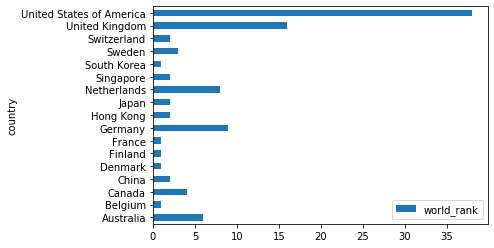

In [52]:
times2016.sort_values('total_score', ascending =False).iloc[0:99,:].groupby('country').count().plot.barh(y='world_rank')

World universities are now ranked by their overall research score and the number of universities in the top 100 by country is plotted below.

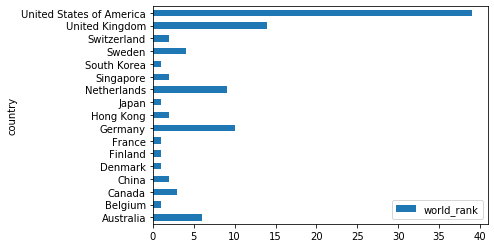

In [53]:
times2016.sort_values('research_score', ascending =False).iloc[0:99,:].groupby('country').count().plot.barh(y='world_rank')

As can be seen, the distribution resulting from our overall overall research score does not differ much from the one arising from the total score defined in the THE ranking. This means that the THE ranking is rather imbalanced towards research rather than education. Things, however, change when we consider the overall teaching score.

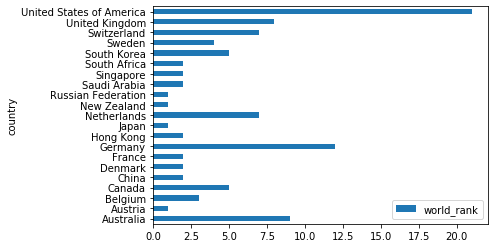

In [54]:
times2016.sort_values('teaching_score', ascending =False).iloc[0:99,:].groupby('country').count().plot.barh(y='world_rank')

In this case, the number of Anglo-Saxon universities is greatly reduced in favor of various other countries. South Africa, Saudi Arabia, Russian Federation, New Zealand and Austria are also represented in the ranking based on the overall teaching score.

### Analysis of university clusters

The same analysis can be repeated by grouping the universities by cluster instead of country.

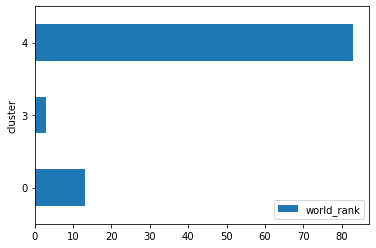

In [55]:
times2016.sort_values('total_score', ascending =False).iloc[0:99,:].groupby('cluster').count().plot.barh(y='world_rank')

It can be noticed that 80% of the top 100 universities according to the THE total score belong to cluster 4, whereas clusters 1, 2 and 5 are not represented. We can also take into account our overall teaching score, as in the figure below.

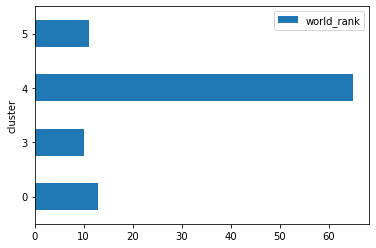

In [56]:
times2016.sort_values('teaching_score', ascending =False).iloc[0:99,:].groupby('cluster').count().plot.barh(y='world_rank')

In this case, the percentage of top 100 universities in cluster 4 drops to slightly above 60%. Also, cluster 5 contains 10% of the top 100 universities according to the overall teaching score.

The clusters of "similar" universities obtained with the KMeans algorithm are analyzed by means of box plots for each variable of interest. Box plots show the distribution of samples in the four quartiles of a given variable and also show points that are determined to be outliers with a method that is a function of the inter-quartile range.

#### Teaching

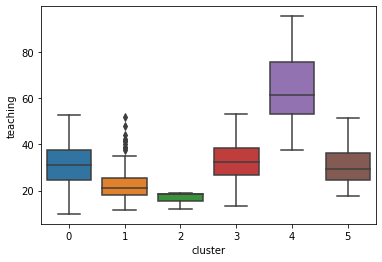

In [57]:
sns.boxplot(x="cluster", y="teaching", data=times2016_new)

Clusters 0, 3 and 5 have similar range of teaching score, whereas cluster 4 stands out. This is consistent with the previous barplot distribution of top 100 universities according to teaching quality.

#### International outlook

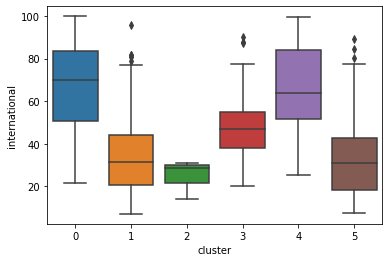

In [58]:
sns.boxplot(x="cluster", y="international", data=times2016_new)

This plot shows that the international outlook performance of clusters 0 and 4 is comparable.

#### Research

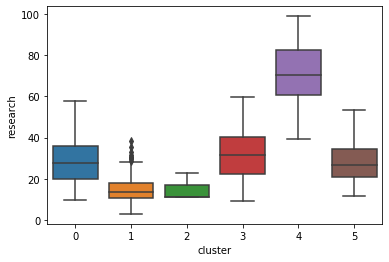

In [59]:
sns.boxplot(x="cluster", y="research", data=times2016_new)

According to this boxplot, cluster 4 stands out for the quality of research as it did for the quality of teaching. Clusters 1 and 2, on the contrary, show the poorest performance.

#### Citations

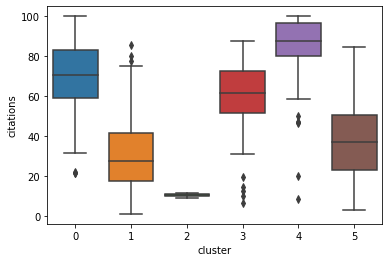

In [60]:
sns.boxplot(x="cluster", y="citations", data=times2016_new)

Interestingly, the citations score distribution is not directly proportional to the research score. Clusters 0 and 3, in particular, seem to get more attention to their research than the actual research score would imply.

#### Industry income

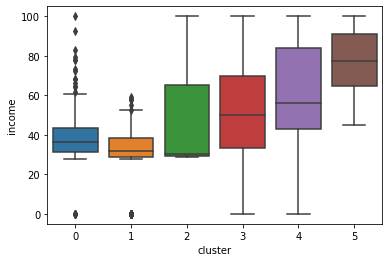

In [61]:
sns.boxplot(x="cluster", y="income", data=times2016_new)

In this case, only cluster 5 stands out for the industry income score, which does not seem to be correlated with the other variables.

#### Number of students

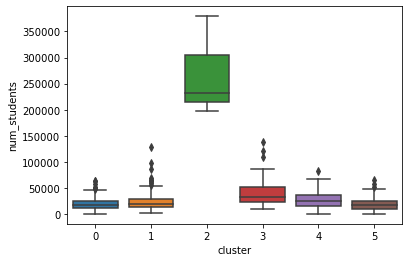

In [62]:
sns.boxplot(x="cluster", y="num_students", data=times2016_new)

Cluster 2 stands out for the number of students, with a quarter of its universities having more than 300 thousands students. This also raises the question whether it makes sense to compare in the same ranking universities hosting a few thousands students with universities hosting a number of students two orders of magnitude higher.

#### Students-to-staff ratio

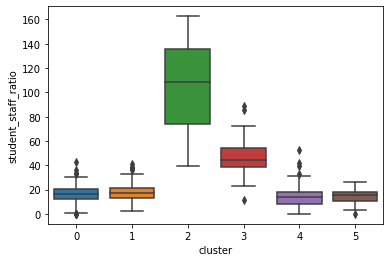

In [63]:
sns.boxplot(x="cluster", y="student_staff_ratio", data=times2016_new)

In this case, the student-to-staff ratio follows the overall trend of the number of students: crowded universities tend to have less teachers per student. 

## Discussion

The analysis of this database highlights the fact that the Times Higher Education ranking gives a greater importance to the volume and reputation of research produced by universities. As a result, Anglo-Saxon universities dominate the ranking. If, on the contrary, we shift the weight to teaching quality, international outlook and relationship with the industrial world, more countries enter the top 100 position of the ranking. The application of machine learning also helped getting better insight in this database. For instance, it has revealed that universities with very high number of students tend to achieve a lower performance in terms of research and teaching quality. However, it doesn't seem fair to compare them in the same ranking with universities that admit fewer students and therefore have a completely different internal organisation.

## Conclusion

In this report, we have analyzed the influential Times Higher Education world university ranking. This ranking encompasses institutions of rather different nature and purpose (small colleges, big universities, technological institutions) and is based on a weighted sum of a number of parameters. The weighs are arbitrarily chosen so as to give more importance to certain parameters related to the volume and influence of the research publications produced by each university. We have shown that by re-grouping these parameters and modifying their relative weight, the group of countries having at least one university among the top 100 becomes more diverse. This work is meant to encourage perspective undergraduate and graduate students to form their own opinion about the quality of education that they can receive in a given country.